In [1]:
import client
import server
import utils

In [2]:
import importlib
importlib.reload(client)
importlib.reload(server)
importlib.reload(utils)

<module 'utils' from '/Users/gael/Desktop/het-opl/src/utils.py'>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from vowpalwabbit.sklearn import VW
from sklearn.model_selection import train_test_split

In [4]:
np.random.seed(42)

### Generate data from homogeneous clients

In [5]:
def givens_rotation(vec, i, j, theta):
    """
    Apply a Givens rotation to a 1D NumPy array in the plane spanned by two given axes.

    Args:
    vec (np.array): The input 1D NumPy array.
    i (int): The first axis.
    j (int): The second axis.
    theta (float): The rotation angle in radians.

    Returns:
    np.array: The resulting 1D NumPy array after applying the Givens rotation.
    """
    if i >= len(vec) or j >= len(vec):
        raise ValueError("Axes indices must be within the range of the input array.")

    if i == j:
        raise ValueError("Axes indices must be different.")

    rotated_vec = vec.copy()
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotated_vec[i] = cos_theta * vec[i] - sin_theta * vec[j]
    rotated_vec[j] = sin_theta * vec[i] + cos_theta * vec[j]

    return rotated_vec

def generate_separated_vectors_grid(n, s, k, num_vectors=4):
    # Calculate the number of cells along each axis
    num_cells = int(np.ceil(2 * s / k))

    # Create a list of all cell indices
    cell_indices = np.arange(num_cells ** n)
    np.random.shuffle(cell_indices)

    # Randomly select distinct cells for each of the num_vectors points
    selected_cells = cell_indices[:num_vectors]

    # Convert cell indices to n-dimensional grid indices
    grid_indices = np.array(np.unravel_index(selected_cells, [num_cells] * n)).T

    # Calculate the lower bound of each cell
    lower_bounds = -s + grid_indices * k

    # Sample a point within each of the chosen cells
    vectors = lower_bounds + np.random.rand(num_vectors, n) * k

    return vectors

def generate_observational_data(num_clients, num_actions, num_features, train_sizes, test_sizes=None):
    if test_sizes is None:
        test_sizes = [10_000] * num_clients

#     action_vec = np.random.randn(num_features)
#     action_vec /= np.linalg.norm(action_vec)
#     # action_vec *= 0.5
    
#     thetas = [k*np.pi/num_actions for k in range(num_actions)]
#     action_params = np.array([givens_rotation(action_vec, 0, 1, theta) for theta in thetas])
#     assert action_params.shape == (num_actions, num_features)

#     # action_params = np.random.randn(num_features, num_actions)
    # action_params /= np.linalg.norm(action_params, axis=0)
    # action_params = 0.5 * action_params

    action_params = generate_separated_vectors_grid(num_features, 1, np.sqrt(num_features), 4)

    for i in range(num_actions):
        other_vectors = np.delete(action_params, [i], axis=0)
        if not all(np.linalg.norm(action_params[i] - v) > np.sqrt(num_features) for v in other_vectors):
            raise ValueError("Vectors not sufficiently separated. Try running again.")

    data = {}
    aux = {}
    for client_id in range(num_clients):
        # Generate data
        num_samples = train_sizes[client_id] + test_sizes[client_id]
        # contexts = np.random.uniform(low=-1, high=1, size=(num_samples, num_features))
        contexts = np.random.normal(loc=0, scale=1, size=(num_samples, num_features)) 
        rewards_vectors = np.zeros((num_samples, num_actions))
        for i in range(num_samples):
            for a in range(num_actions):
                rewards_vectors[i, a] += np.dot(contexts[i], action_params[a])
                if contexts[i][0] > 0.25:
                    rewards_vectors[i, a] += -np.max([np.dot(contexts[i], action_params[aprime]) for aprime in range(num_actions)]) 
                # rewards_vectors[i, a] = np.clip(1 / np.linalg.norm(contexts[i] - action_params[a]), a_min=0, a_max=10)
                # rewards_vectors[i, a] = np.exp(1-1/np.linalg.norm(contexts[i]-action_params[a]))
                # rewards_vectors[i, a] = 1 - np.exp(-1/np.linalg.norm(contexts[i]-action_params[a]))
        # actions = np.random.choice(num_actions, p=[0.7, 0.1, 0.1, 0.1], size=num_samples)
        actions = np.random.choice(num_actions, size=num_samples)
        epsilons = np.random.normal(loc=0, scale=1, size=(num_samples, num_actions))
        noisy_rewards_vectors = rewards_vectors + epsilons
        noisy_rewards = noisy_rewards_vectors[np.arange(num_samples), actions]
        
        # Get train-test split
        (X_train, X_test,
         A_train, A_test,
         Y_train, Y_test,
         true_costs_train, true_costs_test) = train_test_split(contexts, actions, noisy_rewards, -rewards_vectors,
                                                               train_size=train_sizes[client_id],
                                                               shuffle=False)

        # Compute AIPW scores
        crossfit_map, mu, e = utils.cross_fit_nuisance_params(X_train, A_train, Y_train, num_actions)
        AIPW_vectors = utils.compute_AIPW_scores(X_train, A_train, Y_train, num_actions, crossfit_map, mu, e)

        # Convert data to VW format
        vw_data = utils.to_vw_format(X_train, A_train, -AIPW_vectors)

        data[client_id] = vw_data
        aux[client_id] = {"X_train": X_train, "X_test": X_test,
                          "A_train": A_train, "A_test": A_test,
                          "Y_train": Y_train, "Y_test": Y_test,
                          "true_costs_train": true_costs_train, "true_costs_test": true_costs_test}
    
    return data, aux

In [7]:
# Federated config
NUM_ROUNDS = 3
NUM_CLIENTS = 4
NUM_ACTIONS = 4
NUM_FEATURES = 10
TRAIN_SIZES = np.array([1, 1, 1, 1]) * 250_000
CLIENT_WEIGHTS = TRAIN_SIZES / np.sum(TRAIN_SIZES)

# Generate data
data, aux = generate_observational_data(num_clients=NUM_CLIENTS,
                                        num_actions=NUM_ACTIONS,
                                        num_features=NUM_FEATURES,
                                        train_sizes=TRAIN_SIZES)

### Train optimal model

In [8]:
# Aggregate all data
X_train = []
A_train = []
Y_train = []
true_costs_train = []
true_costs_test = []
X_test = []
for client_id in range(NUM_CLIENTS):
    X_train.extend(aux[client_id]["X_train"])
    A_train.extend(aux[client_id]["A_train"])
    Y_train.extend(aux[client_id]["Y_train"])
    true_costs_train.extend(aux[client_id]["true_costs_train"])
    true_costs_test.extend(aux[client_id]["true_costs_test"])
    X_test.extend(aux[client_id]["X_test"])
X_train = np.array(X_train)
A_train = np.array(A_train)
Y_train = np.array(Y_train)
true_costs_train = np.array(true_costs_train)
true_costs_test = np.array(true_costs_test)
X_test = np.array(X_test)

# Compute AIPW scores
crossfit_map, mu, e = utils.cross_fit_nuisance_params(X_train, A_train, Y_train, NUM_ACTIONS)
noisy_costs_train = -utils.compute_AIPW_scores(X_train, A_train, Y_train, NUM_ACTIONS, crossfit_map, mu, e)
data_train = utils.to_vw_format(X_train, A_train, noisy_costs_train)

# Train model
opt_model = VW(csoaa=NUM_ACTIONS,
               convert_to_vw=False,
               convert_labels=False,
               passes=1)
opt_model.fit(data_train)

# Evaluate on test data
X_test_vw = utils.to_vw_format(X_test)
regret, opt_reward, reward = utils.compute_regret(X_test_vw, opt_model, true_costs_test)
# y_pred = model.predict(X_test_vw)
# print(y_pred[-100:])
# print(model.get_coefs())
print(f"Aggregate: opt_reward={opt_reward}, reward={reward}, regret={regret}")

Aggregate: opt_reward=1.5932096211673565, reward=1.592909293500213, regret=0.0003003276671429263


### Train local model

In [38]:
# # Set sample size
# sample_size = 1000

def train_local_policy(client_id, sample_size):
    # Train on local data
    # client_id = 0
    model = VW(csoaa=NUM_ACTIONS,
               convert_to_vw=False,
               convert_labels=False,
               passes=10)
    model.fit(data[client_id][:sample_size])

    return model

def eval_local_policy(model, client_id=0):
    # Evaluate on test data
    X_test_vw = utils.to_vw_format(aux[client_id]["X_test"])
    local_regret, opt_reward, reward = utils.compute_regret(X_test_vw, model, aux[client_id]["true_costs_test"], opt_model)
    # print(f"Local Client {client_id}: opt_reward={opt_reward}, reward={reward}, regret={regret}")
    # return regret, opt_reward, reward

# def eval_random_policy(client_id=0):
    class Model():
        def predict(self, X):
            return np.random.choice(NUM_ACTIONS, size=len(X_test_vw))
        
    # print(len(X_test_vw))
    
    random_regret, opt_reward, reward = utils.compute_regret(X_test_vw, Model(), aux[client_id]["true_costs_test"], opt_model)
    # print(f"Random Local Client {client_id}: opt_reward={opt_reward}, reward={reward}, regret={regret}")
    return local_regret, random_regret

In [51]:
def run_local_training_experiments(client_id=0, num_iters=3):
    lo = 100
    hi = 10_000
    delta = 100
    local_regrets = []
    random_regrets = []
    for sample_size in range(lo, hi+1, delta):
        local_regret = 0
        random_regret = 0
        for i in range(num_iters):
            local_model = train_local_policy(client_id, sample_size)
            lr, rr = eval_local_policy(local_model)
            local_regret += lr
            random_regret += rr
        local_regrets.append(local_regret/num_iters)
        random_regrets.append(random_regret/num_iters)
        
    return local_regrets, random_regrets

In [52]:
local_regrets, random_regrets = run_local_training_experiments()

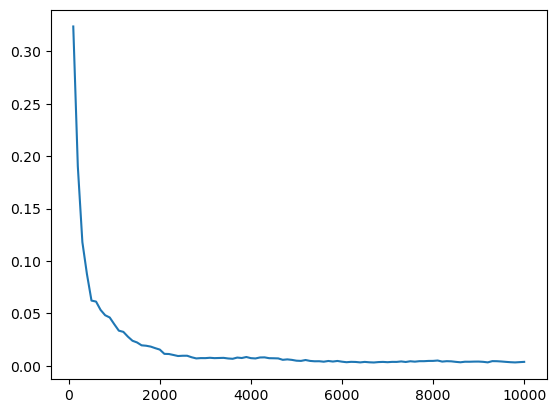

In [53]:
x = 100 * (np.arange(len(local_regrets)) + 1)
plt.plot(x, local_regrets)

### Train federated model

In [ ]:
# Set sample size
sample_sizes = [1000] * NUM_CLIENTS
# sample_sizes[0] = 100

# Subsample data
data_mod = {}
aux_mod = {}
for client_id in range(NUM_CLIENTS):
    sample_size = sample_sizes[client_id]
    data_mod[client_id] = data[client_id][:sample_size]
    aux_mod[client_id] = {"X_test": aux[client_id]["X_test"][:sample_size],
                          "true_costs_test": aux[client_id]["true_costs_test"][:sample_size]}

# Run federated learning
global_vw = server.run_federated_learning(data_mod, aux_mod, opt_model,
                                          num_features=NUM_FEATURES,
                                          num_classes=NUM_ACTIONS,
                                          num_rounds=NUM_ROUNDS,
                                          num_clients=NUM_CLIENTS,
                                          client_weights=CLIENT_WEIGHTS)